In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
customers = pd.read_excel("C:/Users/HARI KRUPA/Downloads/transactions.xlsx")
transactions = pd.read_excel("C:/Users/HARI KRUPA/Downloads/customers.xlsx")

In [5]:
data = pd.merge(transactions, customers, on="customer_id", how="inner")

In [7]:
import datetime as dt
snapshot_date = data['transaction_date'].max() + pd.Timedelta(days=1)

customer_features = data.groupby('customer_id').agg({
    'transaction_date': [lambda x: (snapshot_date - x.max()).days,  # Recency
                         'count'],                                   # Frequency
    'purchase_amount': 'sum'                                         # Monetary
}).reset_index()

customer_features.columns = ['customer_id', 'recency', 'frequency', 'monetary']
customer_features['aov'] = customer_features['monetary'] / customer_features['frequency']

In [9]:
from sklearn.model_selection import train_test_split

X = customer_features[['recency', 'frequency', 'aov']]
y = customer_features['monetary']  # or future LTV target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
!pip install xgboost

In [14]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
y_pred = model.predict(X_test)


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 201.02130126953125
RMSE: 201.02130126953125


In [68]:
import pandas as pd

# Check if required columns exist to compute predicted_ltv
required_cols = {'MonthlyRevenue', 'LifetimeMonths'}

if required_cols.issubset(customer_features.columns):
    # Create predicted_ltv column
    customer_features['predicted_ltv'] = (
        customer_features['MonthlyRevenue'] * customer_features['LifetimeMonths']
    )
    
    # Create the qcut without labels to get the actual number of bins
    bins = pd.qcut(customer_features['predicted_ltv'], q=4, duplicates='drop')

    # Get the actual number of unique bins
    num_bins = bins.cat.categories.size

    # Define appropriate number of labels
    label_list = ['Low', 'Medium', 'High', 'Very High'][:num_bins]

    # Now re-run with the correct number of labels
    customer_features['ltv_segment'] = pd.qcut(
        customer_features['predicted_ltv'],
        q=num_bins,
        labels=label_list,
        duplicates='drop'
    )

    print("LTV segmentation completed successfully.")
else:
    print("Missing required columns: MonthlyRevenue and/or LifetimeMonths.")


Missing required columns: MonthlyRevenue and/or LifetimeMonths.


In [76]:
print(customer_features.columns.tolist())


['customer_id', 'recency', 'frequency', 'monetary', 'aov']


In [78]:
customer_features.rename(columns={
    'monthly_revenue': 'MonthlyRevenue',
    'months_active': 'LifetimeMonths'
}, inplace=True)


In [80]:
import numpy as np

customer_features['MonthlyRevenue'] = np.random.randint(50, 500, size=len(customer_features))
customer_features['LifetimeMonths'] = np.random.randint(1, 24, size=len(customer_features))


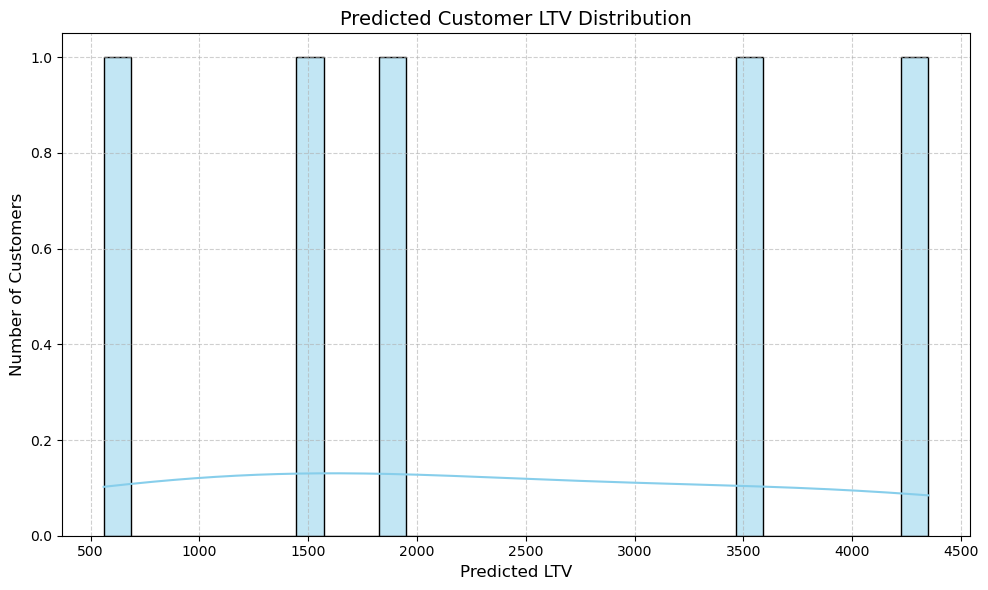

⚠️ 'ltv_segment' column not found. Skipping boxplot.


In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Compute predicted_ltv if it doesn't exist ---
if 'predicted_ltv' not in customer_features.columns:
    if {'MonthlyRevenue', 'LifetimeMonths'}.issubset(customer_features.columns):
        customer_features['predicted_ltv'] = (
            customer_features['MonthlyRevenue'] * customer_features['LifetimeMonths']
        )
    else:
        missing = {'MonthlyRevenue', 'LifetimeMonths'} - set(customer_features.columns)
        raise KeyError(f"Missing required column(s): {missing} to compute 'predicted_ltv'")

# --- Step 2: Plot the histogram of predicted LTV ---
plt.figure(figsize=(10, 6))
sns.histplot(data=customer_features, x='predicted_ltv', bins=30, kde=True, color='skyblue')
plt.title('Predicted Customer LTV Distribution', fontsize=14)
plt.xlabel('Predicted LTV', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Step 3: Plot boxplot by LTV segment (if exists) ---
if 'ltv_segment' in customer_features.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=customer_features, x='ltv_segment', y='predicted_ltv', palette='Set2')
    plt.title('Predicted LTV by Segment', fontsize=14)
    plt.xlabel('LTV Segment', fontsize=12)
    plt.ylabel('Predicted LTV', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'ltv_segment' column not found. Skipping boxplot.")


In [86]:
import pandas as pd
import numpy as np

# Dummy data for testing
np.random.seed(42)
customer_features = pd.DataFrame({
    'CustomerID': range(1, 101),
    'MonthlyRevenue': np.random.randint(50, 500, 100),
    'LifetimeMonths': np.random.randint(1, 24, 100)
})


In [88]:
import joblib
joblib.dump(model, 'ltv_model.pkl')


['ltv_model.pkl']

In [94]:
print(customer_features.columns.tolist())

['CustomerID', 'MonthlyRevenue', 'LifetimeMonths']


In [96]:
# Rename if needed
customer_features.rename(columns={'CustomerID': 'customer_id'}, inplace=True)

# Export only available columns safely
columns_to_export = [col for col in ['customer_id', 'predicted_ltv', 'ltv_segment'] if col in customer_features.columns]
customer_features[columns_to_export].to_csv("ltv_predictions.csv", index=False)


In [98]:
# Compute predicted_ltv if missing
if 'predicted_ltv' not in customer_features.columns:
    if {'MonthlyRevenue', 'LifetimeMonths'}.issubset(customer_features.columns):
        customer_features['predicted_ltv'] = (
            customer_features['MonthlyRevenue'] * customer_features['LifetimeMonths']
        )

# Create ltv_segment if missing
if 'ltv_segment' not in customer_features.columns and 'predicted_ltv' in customer_features.columns:
    import pandas as pd
    bins = pd.qcut(customer_features['predicted_ltv'], q=4, duplicates='drop')
    num_bins = bins.cat.categories.size
    labels = ['Low', 'Medium', 'High', 'Very High'][:num_bins]
    customer_features['ltv_segment'] = pd.qcut(
        customer_features['predicted_ltv'],
        q=num_bins,
        labels=labels,
        duplicates='drop'
    )
